<a href="https://colab.research.google.com/github/TurnipPudding/Machine-Learning---SCC0276/blob/main/Trabalho%202/trab02_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA


In [139]:
!git clone https://github.com/TurnipPudding/Machine-Learning---SCC0276.git
# df = pd.read_csv("processed_microplastics.csv")

fatal: destination path 'Machine-Learning---SCC0276' already exists and is not an empty directory.


In [140]:
print('/content/')

/content/


## Funções Genéricas

### Modelo Genérico

In [141]:
def run_model(model, X_scaled, crossval_results):
    labels = model.fit_predict(X_scaled)

    silhouette = silhouette_score(X_scaled, labels)
    ch_score = calinski_harabasz_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)

    crossval_results.append((silhouette, ch_score, db_score))

    return labels, crossval_results

### PCA

In [142]:
def pca_gen(X_scaled, df, column, title):
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(X_scaled)
    df['PC1'] = pca_components[:, 0]
    df['PC2'] = pca_components[:, 1]

    # print(len(title))
    # print(len(column))
    # Preparar os plots
    fig, axs = plt.subplots(1, len(title), figsize=((len(title) * 6), 5))

    if len(title) == 1:
        axs = [axs]
    # PCA scatter plots
    for i in range(len(title)):
        sns.scatterplot(data=df, x='PC1', y='PC2', hue=column[i], ax=axs[i]).set_title(title[i])
    # sns.scatterplot(data=df, x='PC1', y='PC2', hue='dbscan', ax=axs[1]).set_title("DBSCAN")
    # sns.scatterplot(data=df, x='PC1', y='PC2', hue='agglo', ax=axs[2]).set_title("Agglomerative")

    plt.tight_layout()
    plt.show()

### Boxplot

In [143]:
def boxplot_gen(df, column, title):
    fig, axs = plt.subplots(1, len(title), figsize=((len(title) * 6), 5))

    if len(title) == 1:
        axs = [axs]

    for i in range(len(title)):
        sns.boxplot(data=df, x=column[i], y='index_risk_country', ax=axs[i])
        axs[i].set_title(f"Boxplot do índice de risco por cluster ({title[i]})")
        axs[i].set_xlabel("Cluster")
        axs[i].set_ylabel("Índice de Risco")

    plt.tight_layout()
    plt.show()

### Heatmap

In [192]:
# Usar pivot para criar heatmap país x ano com índice
def heatmap_gen(df):
    pivot_df = df.pivot_table(index='country', columns='year', values='index_risk_country', aggfunc='mean')
    plt.figure(figsize=(14, 10))
    sns.heatmap(pivot_df, cmap='coolwarm', linewidths=0.5)
    plt.title("Heatmap do Índice de Risco Alimentar por País e Ano")
    plt.xlabel("Ano")
    plt.ylabel("País")
    plt.tight_layout()
    plt.show()

### Código para Análise por Ano

In [145]:
def clusterizacao_por_ano(df, col_index='index_risk_country'):
    resultados = []
    anos = sorted(df['year'].unique())

    for ano in anos:
        df_ano = df[df['year'] == ano].copy()

        # Normalização
        scaler = StandardScaler()
        X = scaler.fit_transform(df_ano[[col_index]])

        # Determinação do melhor k com Silhouette Score
        silhouette_scores = []
        for k in range(2, 10):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X)
            score = silhouette_score(X, labels)
            silhouette_scores.append((k, score))

        best_k = max(silhouette_scores, key=lambda x: x[1])[0]

        # Clusterização final
        final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
        df_ano['cluster'] = final_kmeans.fit_predict(X)

        resultados.append(df_ano[['country', 'year', col_index, 'cluster']])

    return pd.concat(resultados, ignore_index=True)



### Código para Análise Geográfica

In [146]:
# --------------------------
# CÓDIGO PARA ANÁLISE GEOGRÁFICA
# --------------------------
def analise_geografica(df_clusterizado, col_index='index_risk_country'):
    return df_clusterizado.groupby('country').agg(
        media_risco=(col_index, 'mean'),
        cluster_mais_comum=('cluster', lambda x: x.mode().iloc[0] if not x.mode().empty else -1)
    ).reset_index()

## Carregando dados

In [147]:
df = pd.read_csv("/content/Machine-Learning---SCC0276/Trabalho 2/processed_microplastics.csv")
df.head(5)

,year,country,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,...,fish,shellfish,eggs,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes,total_ug_per_kg
0,1990,Angola,0.191781,54.899739,96.602740,76.520548,481.297149,44.309838,2.849315,22.770109,...,53.013699,0.164384,1.041096,8.005259,32.547945,80.164384,8.109589,39.342466,19.835616,1043.279108
1,1990,Benin,0.054795,9.365946,18.410959,90.876712,534.256965,48.836323,19.561644,17.018264,...,18.794521,3.972603,2.849315,5.854497,8.246575,122.986301,0.000000,304.904110,21.178082,1241.656197
2,1990,Burkina Faso,0.273973,35.390618,56.027397,19.178082,213.170183,129.416119,28.465753,9.541329,...,4.684932,0.000000,6.767123,6.928378,9.534247,64.767123,2.219178,13.780822,32.520548,666.603927
3,1990,Central African Republic,0.000000,19.206478,48.000000,113.397260,285.035375,302.567776,23.506849,26.412094,...,13.917808,0.000000,1.123288,6.585071,19.698630,101.753425,0.575342,209.452055,12.821918,1237.339905
4,1990,Cote D'Ivoire,0.301370,2.220447,38.109589,37.013699,436.907598,25.220347,16.904110,2.459103,...,51.424658,0.493151,2.438356,9.660915,28.438356,151.150685,1.945205,676.575343,2.356164,1540.502458


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      723 non-null    int64  
 1   country                   723 non-null    object 
 2   cheese                    723 non-null    float64
 3   yoghurt                   723 non-null    float64
 4   total_milk                723 non-null    float64
 5   fruits                    723 non-null    float64
 6   refined_grains            723 non-null    float64
 7   whole_grains              723 non-null    float64
 8   nuts_and_seeds            723 non-null    float64
 9   total_processed_meats     723 non-null    float64
 10  unprocessed_red_meats     723 non-null    float64
 11  fish                      723 non-null    float64
 12  shellfish                 723 non-null    float64
 13  eggs                      723 non-null    float64
 14  total_salt

In [149]:
df.describe()

,year,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,unprocessed_red_meats,fish,shellfish,eggs,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes,total_ug_per_kg
count,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000
mean,2005.113416,6.135622,54.175691,250.655223,198.891339,310.733750,76.090720,12.716421,43.242799,90.326727,40.367154,7.415298,17.184714,6.844069,87.980939,232.405995,81.885598,64.300877,19.261638,1600.614574
std,9.610611,10.437505,77.868834,243.250670,150.271271,138.658231,81.578881,10.827892,39.223624,67.646655,34.835918,13.695479,14.584195,1.806978,60.331304,164.633624,83.109875,135.136514,16.758578,567.115360
min,1990.000000,0.000000,0.748435,1.808219,8.958904,72.797775,0.158798,0.000000,0.396227,6.583087,0.054795,0.000000,0.027397,2.278036,3.972603,16.931507,0.000000,0.000000,0.438356,440.261767
25%,1995.000000,0.273973,12.048883,50.342466,89.808219,216.258939,16.965904,4.561644,11.560798,33.837311,15.726027,0.191781,3.876712,5.845209,38.753425,118.287671,12.205479,0.493151,7.821918,1176.251294
50%,2005.000000,1.424658,35.390618,153.506849,179.945205,288.254183,47.164800,9.589041,29.473811,71.678223,31.232877,1.589041,13.780822,6.660399,83.698630,185.945205,49.561644,8.547945,14.794521,1550.939573
75%,2015.000000,6.082192,73.449547,400.890411,266.863014,383.983087,101.764947,18.410959,66.736055,134.673403,54.506849,8.630137,27.657534,7.659304,117.616438,292.479452,135.876712,59.123288,25.561644,2061.390253
max,2018.000000,65.643836,679.834239,1040.931507,1078.931507,890.394188,434.121124,73.068493,198.333731,477.301388,207.315068,151.863014,61.698630,12.430686,453.780822,1055.342466,362.712329,833.945206,124.575343,3613.131482


In [150]:
df.columns

Index(['year', 'country', 'cheese', 'yoghurt', 'total_milk', 'fruits',
       'refined_grains', 'whole_grains', 'nuts_and_seeds',
       'total_processed_meats', 'unprocessed_red_meats', 'fish', 'shellfish',
       'eggs', 'total_salt', 'added_sugars', 'non-starchy_vegetables',
       'potatoes', 'other_starchy_vegetables', 'beans_and_legumes',
       'total_ug_per_kg'],
      dtype='object')

## Analisando features

In [151]:
#Separando as features de contaminação

colums_to_sum = df.columns.drop(['year', 'country', 'total_salt', 'added_sugars', 'total_ug_per_kg'])
colums_to_sum

Index(['cheese', 'yoghurt', 'total_milk', 'fruits', 'refined_grains',
       'whole_grains', 'nuts_and_seeds', 'total_processed_meats',
       'unprocessed_red_meats', 'fish', 'shellfish', 'eggs',
       'non-starchy_vegetables', 'potatoes', 'other_starchy_vegetables',
       'beans_and_legumes'],
      dtype='object')

In [152]:
#Somando o risco total de contaminação de todos os alimentos pra cada país

df['total_risk'] = df[colums_to_sum].sum(axis=1)
print(df['total_risk'])

0      1002.725904
1      1227.555125
2       650.141303
3      1211.056204
4      1502.403187
          ...     
718    2277.098362
719    1769.617066
720    2191.029349
721    1146.929547
722    1416.493193
Name: total_risk, Length: 723, dtype: float64


In [153]:
#Definindo o índice de risco por país

df['index_risk_country'] = (df['total_risk']*df['total_ug_per_kg']).round(2)
print(df['index_risk_country'])

0      1046122.99
1      1524201.43
2       433386.75
3      1498488.17
4      2314455.80
          ...    
718    5578099.98
719    3409827.76
720    5205821.15
721    1418239.84
722    2053374.47
Name: index_risk_country, Length: 723, dtype: float64


## Normalização

In [154]:
#Normalizando a feature 'index_risk_country'

scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df[['index_risk_country']])
X_scaled = scaler.fit_transform(df[colums_to_sum])

## Testes com KNN

In [155]:
knn = KMeans(n_clusters=3, random_state=42, n_init=10)
knn_labels, knn_cv = run_model(knn, X_scaled, [])

### Cross-validation

In [156]:
print(knn_cv)

[(np.float64(0.16543553437279707), np.float64(162.4970884946564), np.float64(2.08067122733283))]


### PCA

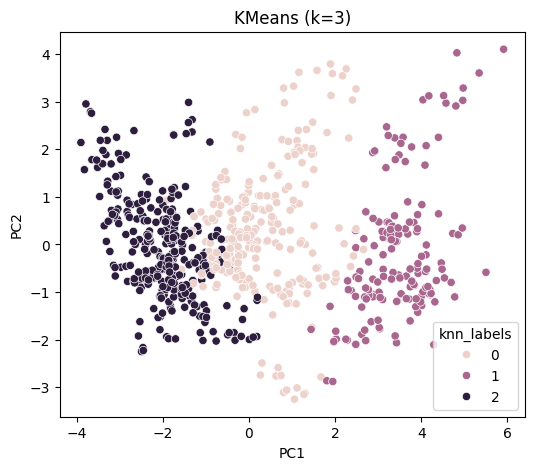

In [157]:
knn_column = 'knn_labels'
knn_title = 'KMeans (k=3)'

df[knn_column] = knn_labels

pca_gen(X_scaled=X_scaled, df=df, column=[knn_column], title=[knn_title])

### Boxplot

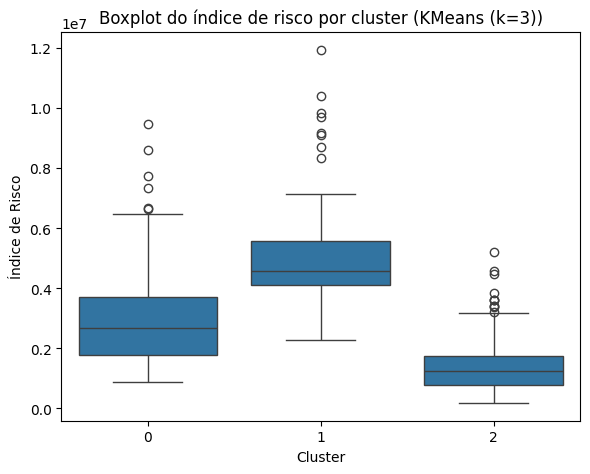

In [158]:
boxplot_gen(df=df, column=[knn_column], title=[knn_title])

### Heatmap

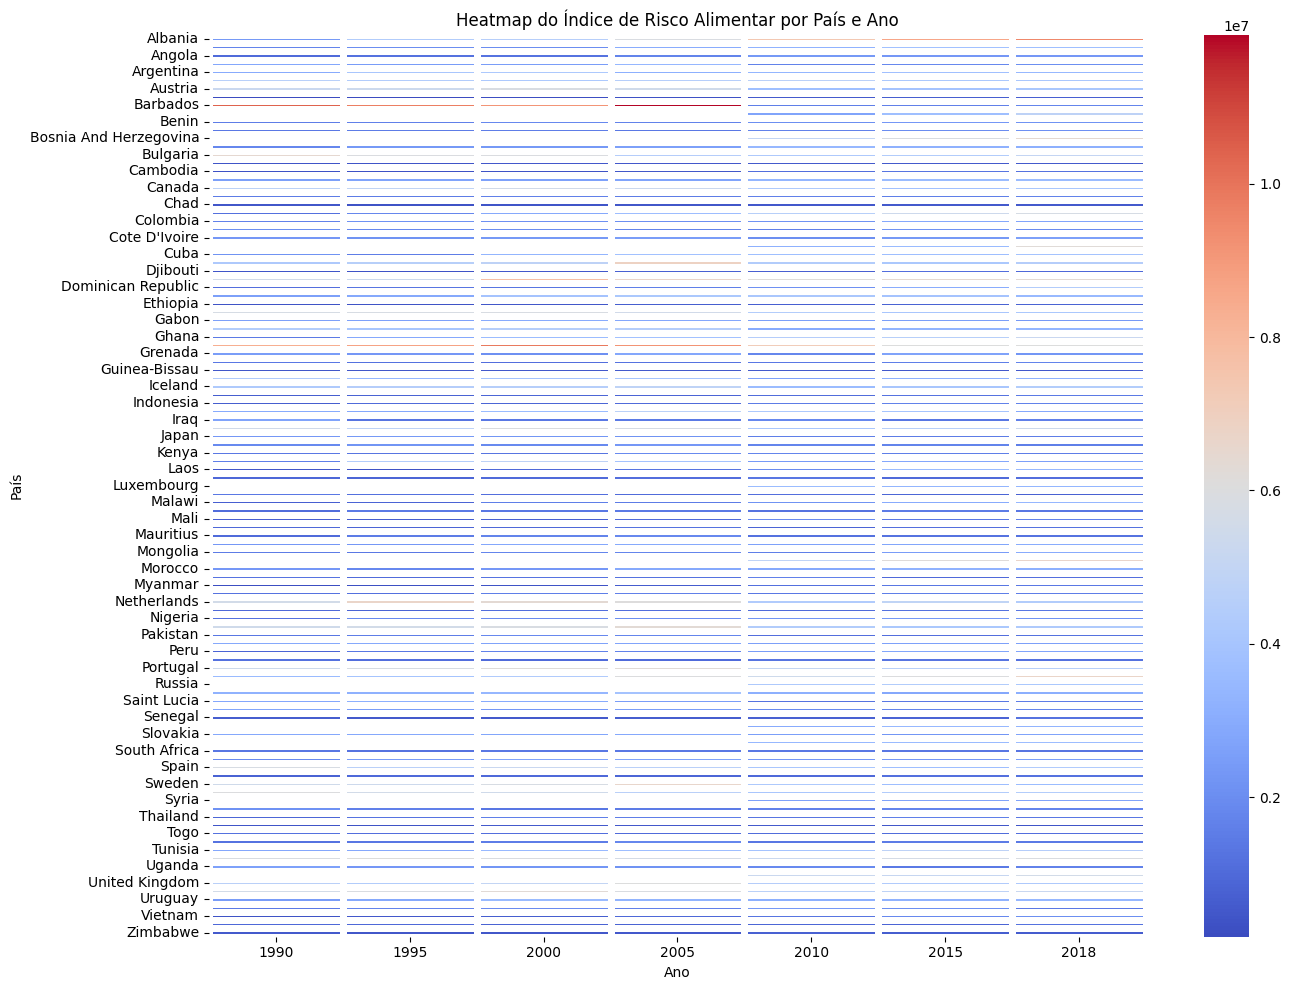

In [193]:
heatmap_gen(df=df)

## Testes com DBSCAN

In [160]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels, dbscan_cv = run_model(dbscan, X_scaled, [])

### Cross-validation

In [161]:
print(dbscan_cv)

[(np.float64(-0.14347073086707862), np.float64(3.2158254834759794), np.float64(1.3994300737036078))]


### PCA

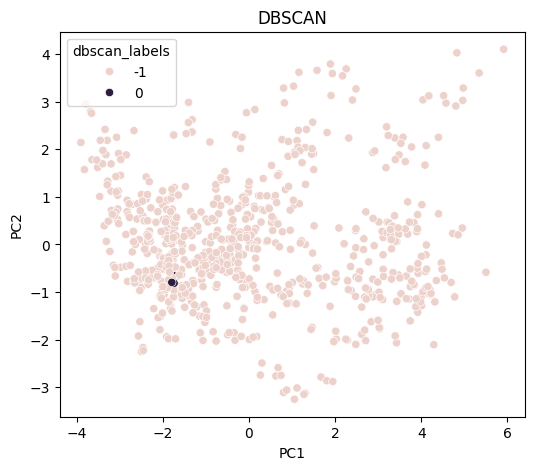

In [162]:
dbscan_column = 'dbscan_labels'
dbscan_title = 'DBSCAN'

df[dbscan_column] = dbscan_labels

pca_gen(X_scaled=X_scaled, df=df, column=[dbscan_column], title=[dbscan_title])

### Boxplot

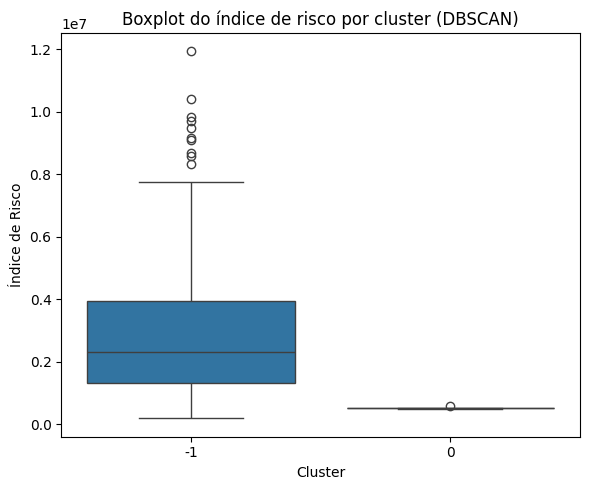

In [163]:
boxplot_gen(df=df, column=[dbscan_column], title=[dbscan_title])

### Heatmap

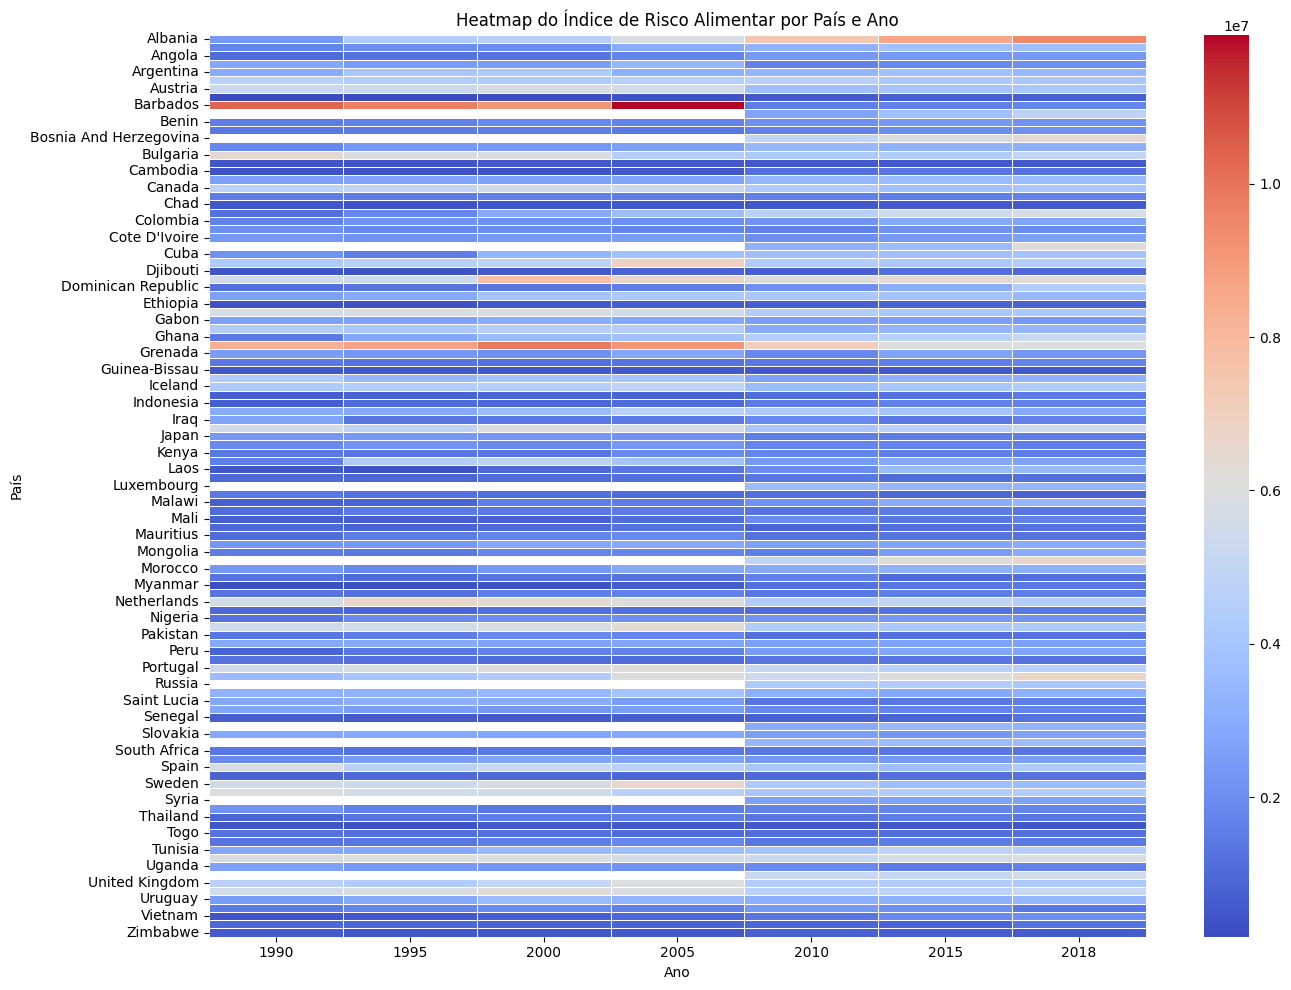

In [164]:
heatmap_gen(df=df)

## Testes com Agglomerative Clustering

In [165]:
agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels, agglo_cv = run_model(agglo, X_scaled, [])

### Cross-validation

In [166]:
print(agglo_cv)

[(np.float64(0.1324223343753308), np.float64(146.62037361726425), np.float64(2.2345606376294187))]


### PCA

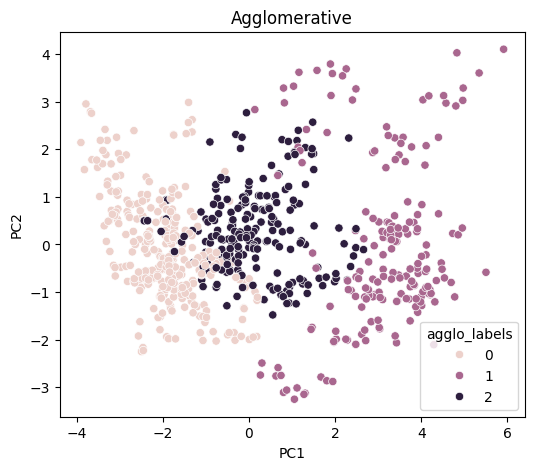

In [167]:
agglo_column = 'agglo_labels'
agglo_title = 'Agglomerative'

df[agglo_column] = agglo_labels

pca_gen(X_scaled=X_scaled, df=df, column=[agglo_column], title=[agglo_title])

### Boxplot

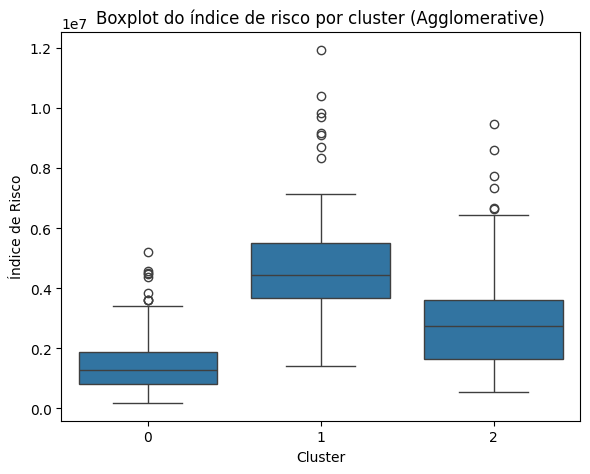

In [168]:
boxplot_gen(df=df, column=[agglo_column], title=[agglo_title])

### Heatmap

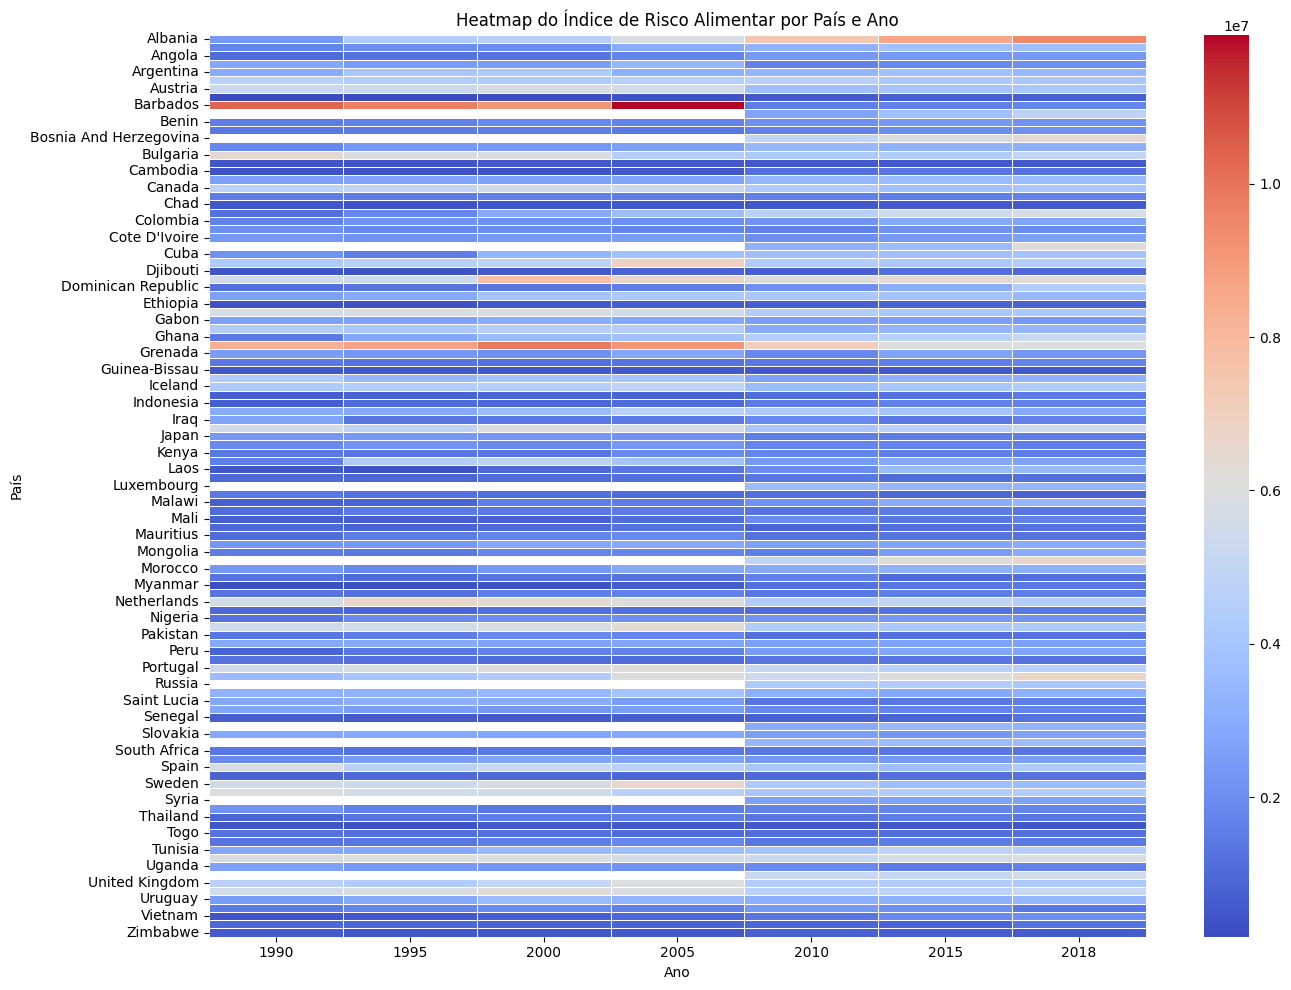

In [169]:
heatmap_gen(df=df)

## Análise entre modelos

### Cross-validation

In [170]:
models_cv = pd.concat([pd.DataFrame(knn_cv, columns=['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin]']),
           pd.DataFrame(dbscan_cv, columns=['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin]']),
           pd.DataFrame(agglo_cv, columns=['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin]'])],
          axis=1, keys=['KMeans', 'DBSCAN', 'Agglomerative'])

### PCA

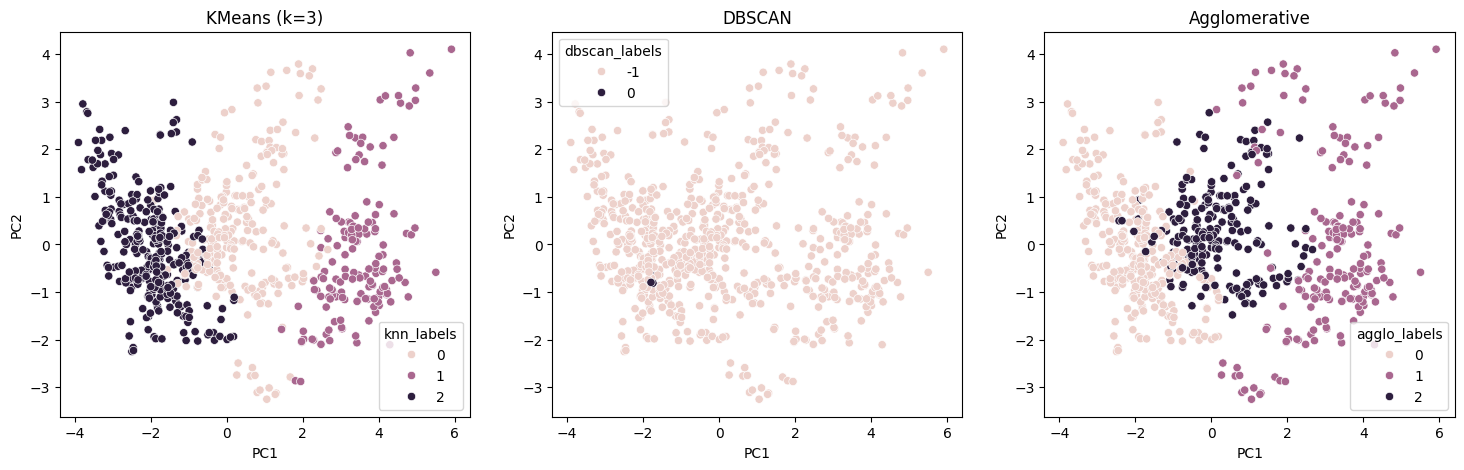

In [171]:
pca_gen(X_scaled=X_scaled, df=df,
        column=[knn_column, dbscan_column, agglo_column],
        title=[knn_title, dbscan_title, agglo_title])

### Boxplot

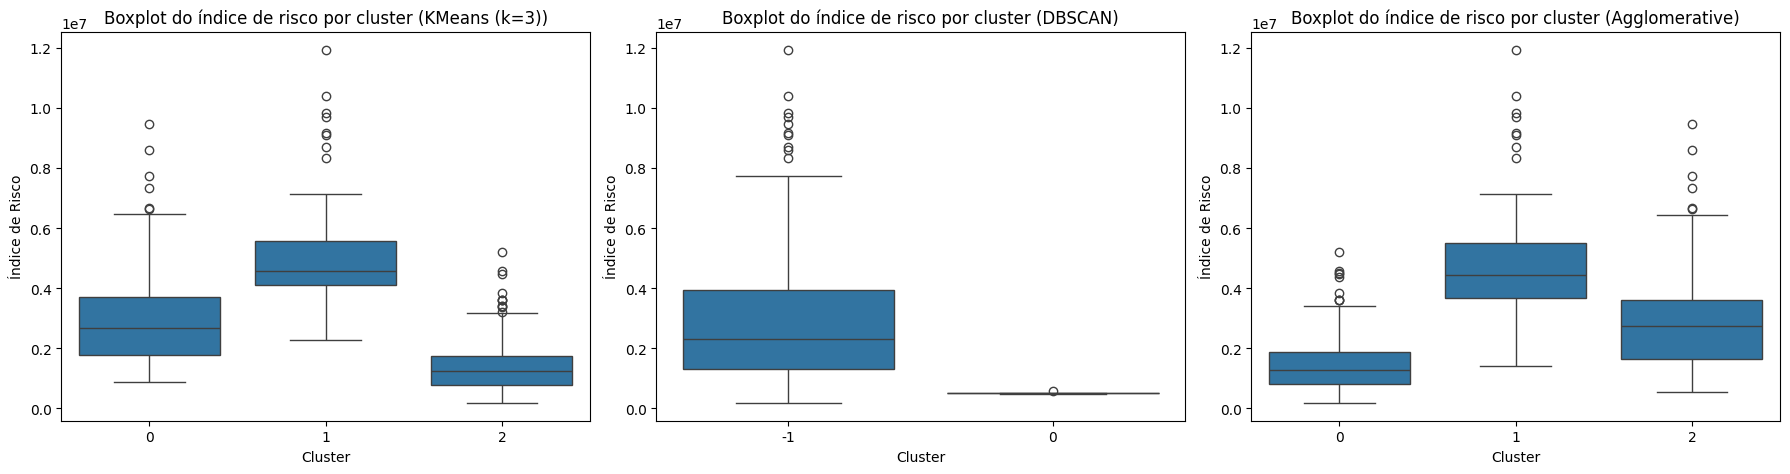

In [172]:
boxplot_gen(df=df, column=[knn_column, dbscan_column, agglo_column],
            title=[knn_title, dbscan_title, agglo_title])

### Heatmap

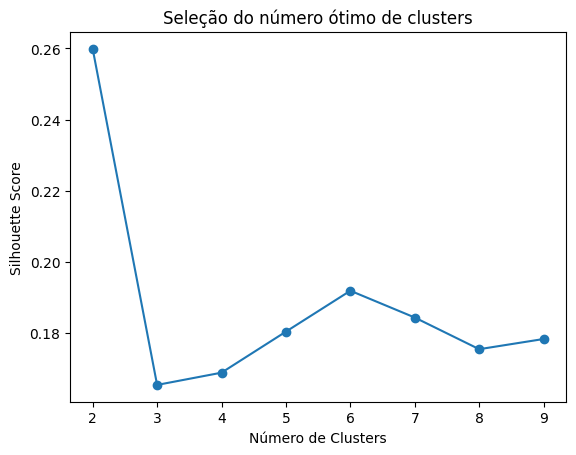

In [173]:
#Definição do número ideal de clusters via Silhouette Score

s_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    s_scores.append(silhouette_score(X_scaled, labels))

# Visualização
plt.plot(K, s_scores, marker='o')
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score")
plt.title("Seleção do número ótimo de clusters")
plt.show()

In [174]:
#Clusterização final com KMeans

best_k = K[s_scores.index(max(s_scores))]

kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)


In [175]:
# print(df[['country','cluster']])

## Análise de Clusters

In [176]:
#Análise dos clusters

# Média do índice de risco por cluster
# df.groupby('cluster')['index_risk_country'].mean()

In [177]:
# sns.boxplot(data=df, x='cluster', y='index_risk_country')
# plt.title("Distribuição do índice de risco por cluster")

In [178]:
df_clusters_por_ano = clusterizacao_por_ano(df)
df_clusters_por_ano

,country,year,index_risk_country,cluster
0,Angola,1990,1046122.99,0
1,Benin,1990,1524201.43,0
2,Burkina Faso,1990,433386.75,0
3,Central African Republic,1990,1498488.17,0
4,Cote D'Ivoire,1990,2314455.80,0
...,...,...,...,...
718,Ukraine,2018,5578099.98,2
719,Uruguay,2018,3409827.76,1
720,United States,2018,5205821.15,2
721,Venezuela,2018,1418239.84,0


In [179]:
df_resumo_geografico = analise_geografica(df_clusters_por_ano)
df_resumo_geografico

,country,media_risco,cluster_mais_comum
0,Albania,6.074082e+06,1
1,Algeria,2.794925e+06,1
2,Angola,1.739975e+06,0
3,Antigua And Barbuda,2.397377e+06,0
4,Argentina,3.569469e+06,1
...,...,...,...
104,Uruguay,3.141486e+06,0
105,Venezuela,1.797755e+06,0
106,Vietnam,1.100288e+06,0
107,Zambia,9.229976e+05,0


### CROSS-VALIDATION DOS CLUSTERS

In [180]:

crossval_results = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
    ch_score = calinski_harabasz_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    crossval_results.append((k, silhouette, ch_score, db_score))

crossval_results

[(2,
  np.float64(0.2595518314194714),
  np.float64(225.33119481695593),
  np.float64(1.6373582257644643)),
 (3,
  np.float64(0.16543553437279707),
  np.float64(162.4970884946564),
  np.float64(2.08067122733283)),
 (4,
  np.float64(0.1719714249206558),
  np.float64(137.11399430405305),
  np.float64(2.002286914124944)),
 (5,
  np.float64(0.1744355868144263),
  np.float64(122.8015697927841),
  np.float64(1.8936255884342053)),
 (6,
  np.float64(0.18161035453400215),
  np.float64(109.11952564242331),
  np.float64(1.791061526533049)),
 (7,
  np.float64(0.18105196978940374),
  np.float64(106.56640356786609),
  np.float64(1.6330911616902704)),
 (8,
  np.float64(0.17549778387496978),
  np.float64(100.39166826713982),
  np.float64(1.5573181814615498)),
 (9,
  np.float64(0.1914090697516513),
  np.float64(98.67778018062977),
  np.float64(1.5971966250569891))]

## Testes com DBSCAN


In [181]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

## Testes com Agglomerative Clustering


In [182]:
agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels = agglo.fit_predict(X_scaled)

In [183]:
# Adicionar rótulos ao DataFrame para visualização
df['kmeans_3'] = KMeans(n_clusters=3, random_state=42, n_init=10).fit_predict(X_scaled)
df['dbscan'] = dbscan_labels
df['agglo'] = agglo_labels

## Visualizações


### PCA


In [184]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
df['PC1'] = pca_components[:, 0]
df['PC2'] = pca_components[:, 1]

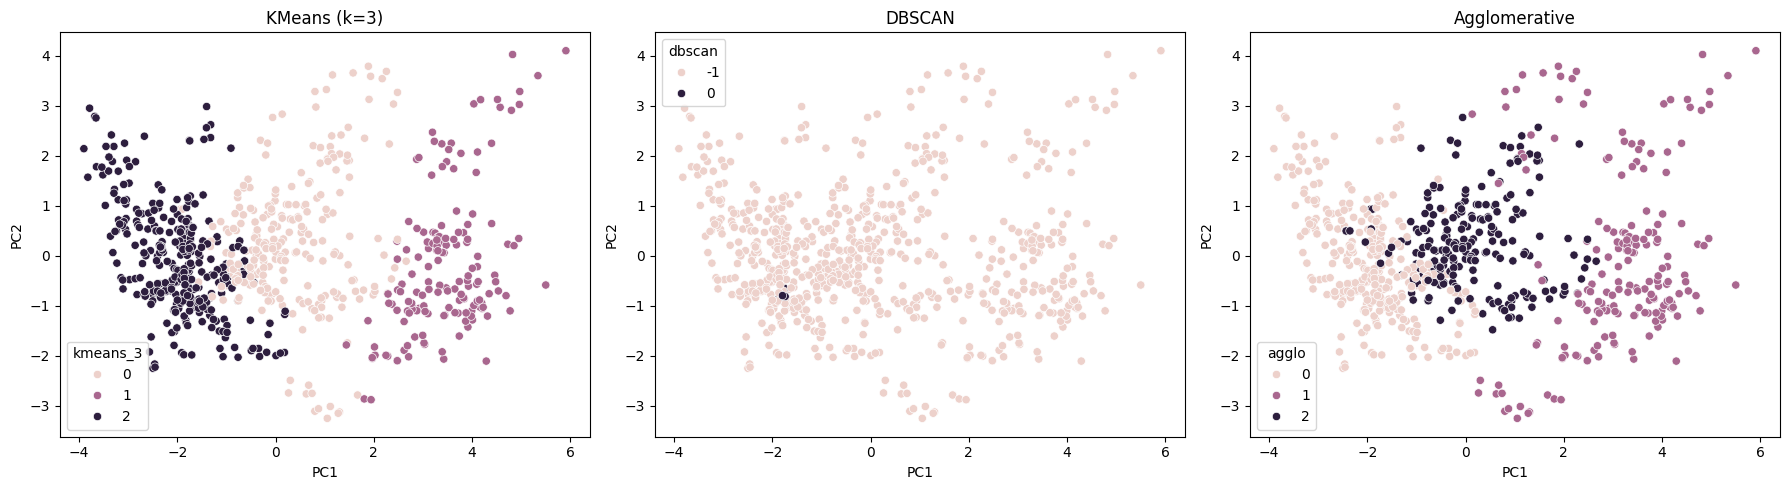

In [185]:
# Preparar os plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# PCA scatter plots
sns.scatterplot(data=df, x='PC1', y='PC2', hue='kmeans_3', ax=axs[0]).set_title("KMeans (k=3)")
sns.scatterplot(data=df, x='PC1', y='PC2', hue='dbscan', ax=axs[1]).set_title("DBSCAN")
sns.scatterplot(data=df, x='PC1', y='PC2', hue='agglo', ax=axs[2]).set_title("Agglomerative")

plt.tight_layout()
plt.show()

### BOXPLOT


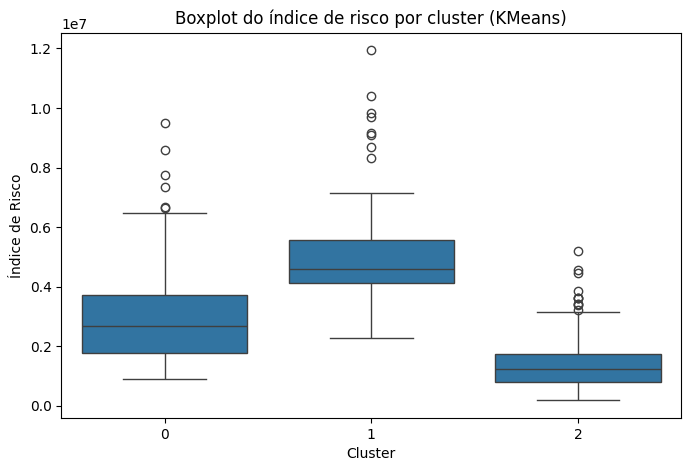

In [186]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='kmeans_3', y='index_risk_country')
plt.title("Boxplot do índice de risco por cluster (KMeans)")
plt.xlabel("Cluster")
plt.ylabel("Índice de Risco")
plt.show()



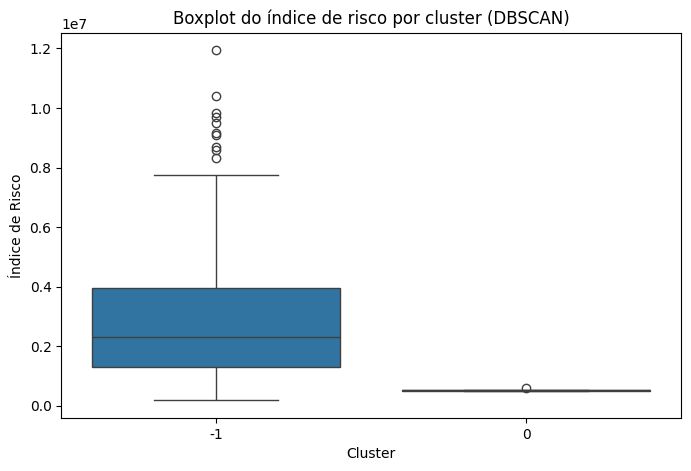

In [187]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='dbscan', y='index_risk_country')
plt.title("Boxplot do índice de risco por cluster (DBSCAN)")
plt.xlabel("Cluster")
plt.ylabel("Índice de Risco")
plt.show()

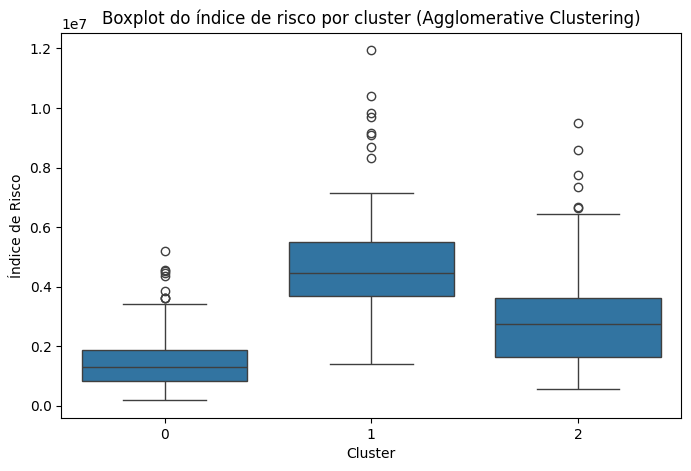

In [188]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='agglo', y='index_risk_country')
plt.title("Boxplot do índice de risco por cluster (Agglomerative Clustering)")
plt.xlabel("Cluster")
plt.ylabel("Índice de Risco")
plt.show()


### HEATMAP


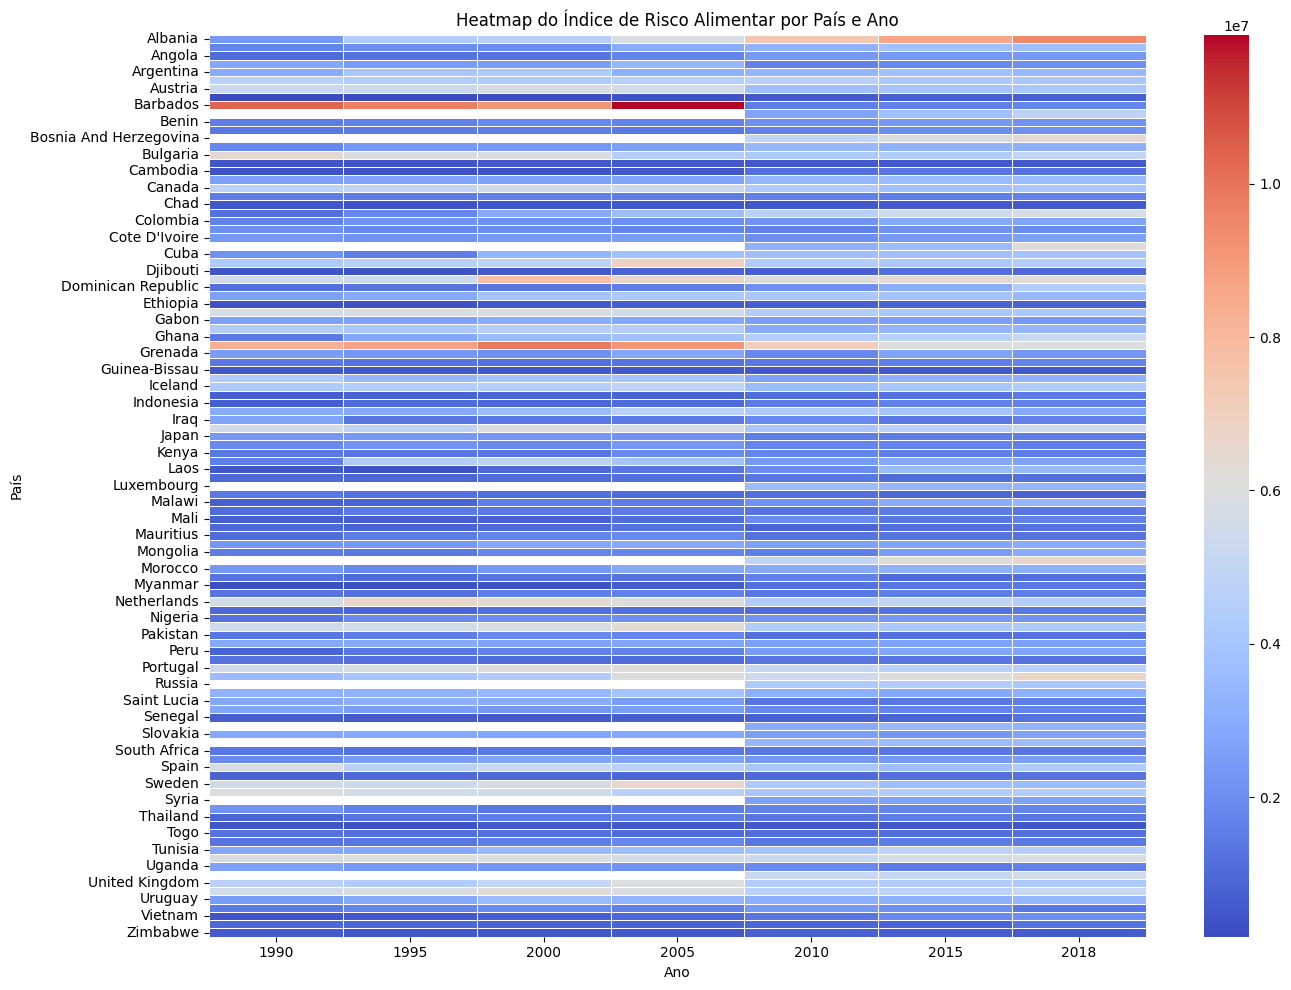

[(2,
  np.float64(0.2595518314194714),
  np.float64(225.33119481695593),
  np.float64(1.6373582257644643)),
 (3,
  np.float64(0.16543553437279707),
  np.float64(162.4970884946564),
  np.float64(2.08067122733283)),
 (4,
  np.float64(0.1719714249206558),
  np.float64(137.11399430405305),
  np.float64(2.002286914124944)),
 (5,
  np.float64(0.1744355868144263),
  np.float64(122.8015697927841),
  np.float64(1.8936255884342053)),
 (6,
  np.float64(0.18161035453400215),
  np.float64(109.11952564242331),
  np.float64(1.791061526533049)),
 (7,
  np.float64(0.18105196978940374),
  np.float64(106.56640356786609),
  np.float64(1.6330911616902704)),
 (8,
  np.float64(0.17549778387496978),
  np.float64(100.39166826713982),
  np.float64(1.5573181814615498)),
 (9,
  np.float64(0.1914090697516513),
  np.float64(98.67778018062977),
  np.float64(1.5971966250569891))]

In [189]:
# Usar pivot para criar heatmap país x ano com índice
pivot_df = df.pivot_table(index='country', columns='year', values='index_risk_country', aggfunc='mean')
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_df, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap do Índice de Risco Alimentar por País e Ano")
plt.xlabel("Ano")
plt.ylabel("País")
plt.tight_layout()
plt.show()

# Retornar resultados de cross-validation
crossval_results